In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from IPython.display import Audio
import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
data_dir = r'C:\Users\bhara\OneDrive\Desktop\SER by CNN\TESS Toronto emotional speech set data'


In [5]:
# Initialize empty lists for features and labels
features = []
labels = []

# Iterate through the folders
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        emotion_label = folder.split('_')[-1]  # Extract the emotion label from the folder name
        
        # Get the list of WAV files in the current folder
        wav_files = [file for file in os.listdir(folder_path) if file.endswith('.wav')]
        
        # Process each WAV file in the folder
        for file_name in wav_files:
            file_path = os.path.join(folder_path, file_name)
            audio, sr = librosa.load(file_path, duration=3)
            mfcc_mean = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13), axis=1)
                
            # Append features and labels
            features.append(mfcc_mean)
            labels.append(emotion_label)


In [4]:
features = np.array(features)
labels = np.array(labels)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
# Define the emotions and the number of samples to select from each emotion
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
num_samples_per_emotion = 3
# Initialize empty lists for storing the selected samples
selected_samples = []
# Iterate through the emotions and select samples
for emotion in emotions:
    emotion_dir = os.path.join(data_dir, f'OAF_{emotion}')
    audio_files = os.listdir(emotion_dir)
    selected_files = np.random.choice(audio_files, size=num_samples_per_emotion, replace=False)
    
    for file_name in selected_files:
        file_path = os.path.join(emotion_dir, file_name)
        audio, sr = librosa.load(file_path, duration=3)
        selected_samples.append((audio, sr, emotion))
        

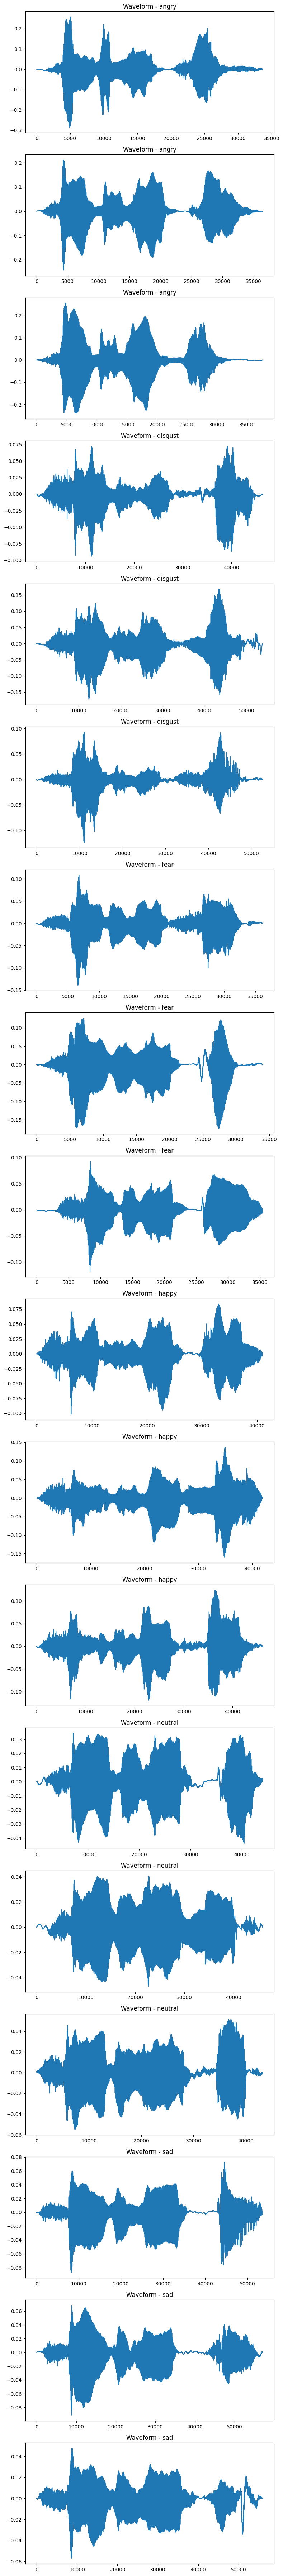

In [5]:
# Plot the selected samples
num_samples = len(selected_samples)
plt.figure(figsize=(8, 4 * num_samples))

for i, (audio, sr, emotion) in enumerate(selected_samples):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(audio)
    plt.title(f'Waveform - {emotion}')

plt.tight_layout()
plt.show()


In [6]:
import os
import numpy as np
import librosa
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout

class AudioAugmentation:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.sr = 22050  # Default sampling rate
        self.features = []
        self.audio_data = []
        self.labels = []

    def add_noise(self, data, noise_factor=0.005):
        noise = noise_factor * np.random.randn(len(data))
        return data + noise

    def time_stretch(self, data, rate=1.2):
        return librosa.effects.time_stretch(data, rate=rate)

    def pitch_shift(self, data, sampling_rate, pitch_factor=0.7):
        return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

    def extract_features(self, audio):
        mfcc = librosa.feature.mfcc(y=audio, sr=self.sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        return mfcc_mean

    def time_masking(self, data, mask_factor=10):
        masked_data = data.copy()
        for _ in range(mask_factor):
            start = np.random.randint(0, len(data))
            mask_len = np.random.randint(1, len(data) // 20)  # Mask up to 5% of the data
            masked_data[start : start + mask_len] = 0
        return masked_data

    def load_data(self):
        for folder in os.listdir(self.data_dir):
            folder_path = os.path.join(self.data_dir, folder)
            if os.path.isdir(folder_path):
                emotion_label = folder.split('_')[-1]  # Extract the emotion label from the folder name
                
                for file_name in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file_name)
                    if file_path.endswith('.wav'):
                        # Load the audio file
                        audio, sr = librosa.load(file_path, duration=3)  # Adjust the duration as needed
                        self.sr = sr  # Update sampling rate
                        mfcc_mean = self.extract_features(audio)
                        self.features.append(mfcc_mean)
                        self.audio_data.append(audio)
                        self.labels.append(emotion_label)

    def augment_data_generator(self):
        for audio, feature, label in zip(self.audio_data, self.features, self.labels):
            yield feature, label

            # Apply noise addition
            noisy_audio = self.add_noise(audio)
            mfcc_noisy = self.extract_features(noisy_audio)
            yield mfcc_noisy, label

            # Apply time stretching
            stretched_audio = self.time_stretch(audio, rate=1.2)
            mfcc_stretched = self.extract_features(stretched_audio)
            yield mfcc_stretched, label

            # Apply pitch shifting
            pitched_audio = self.pitch_shift(audio, self.sr, pitch_factor=0.7)
            mfcc_pitched = self.extract_features(pitched_audio)
            yield mfcc_pitched, label

            # Apply time masking
            masked_audio = self.time_masking(audio)
            mfcc_masked = self.extract_features(masked_audio)
            yield mfcc_masked, label

# Instantiate the augmentation class


audio_aug = AudioAugmentation(data_dir)

# Load data
audio_aug.load_data()

# Print the number of original samples
print('Original samples:', len(audio_aug.features))

# Augment the data using generators
augmented_data_generator = audio_aug.augment_data_generator()

# Calculate the number of augmented samples
num_augmented_samples = len(audio_aug.audio_data) * 5  # 5 augmentation techniques used
print('Augmented samples:', num_augmented_samples)


Original samples: 2800
Augmented samples: 14000


In [7]:
# Encode the emotion labels
label_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
encoded_labels = np.array([label_mapping.get(label, -1) for label in labels])

# Debug: Print the encoded labels
print("Encoded labels before filtering:", encoded_labels)

# Filter out any samples with unknown emotion labels
valid_indices = np.where(encoded_labels != -1)[0]  # Get the indices from the tuple
print("Valid indices:", valid_indices)  # Debug: Print the valid indices
features = features[valid_indices]
encoded_labels = encoded_labels[valid_indices]

# Debug: Print the encoded labels after filtering
print("Encoded labels after filtering:", encoded_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Reshape the input features
X_train = X_train.reshape((*X_train.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))

# Convert the emotion labels to categorical format
num_classes = len(label_mapping)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Encoded labels before filtering: [0 0 0 ... 5 5 5]
Valid indices: [   0    1    2 ... 2797 2798 2799]
Encoded labels after filtering: [0 0 0 ... 5 5 5]


In [8]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1600, 13, 1)
y_train shape: (1600, 6)
X_test shape: (400, 13, 1)
y_test shape: (400, 6)


In [77]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the model
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(13, 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output
model.add(Flatten())

# Add dense layers
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)                   │ (None, 11, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 3, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,654 (358.02 KB)

 Trainable params: 91,654 (358.02 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2390 - loss: 4.4917 - val_accuracy: 0.5825 - val_loss: 1.1460
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6258 - loss: 0.9659 - val_accuracy: 0.7800 - val_loss: 0.6560
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7738 - loss: 0.6371 - val_accuracy: 0.8350 - val_loss: 0.5245
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8232 - loss: 0.4990 - val_accuracy: 0.8600 - val_loss: 0.4384
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8237 - loss: 0.4392 - val_accuracy: 0.8675 - val_loss: 0.3724
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8663 - loss: 0.3906 - val_accuracy: 0.8850 - val_loss: 0.3423
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8875 - loss: 0.3224 - val_accuracy: 0.9100 - val_loss: 0.3026
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9127 - loss: 0.2621 - val_accuracy: 0.8750 - val_loss

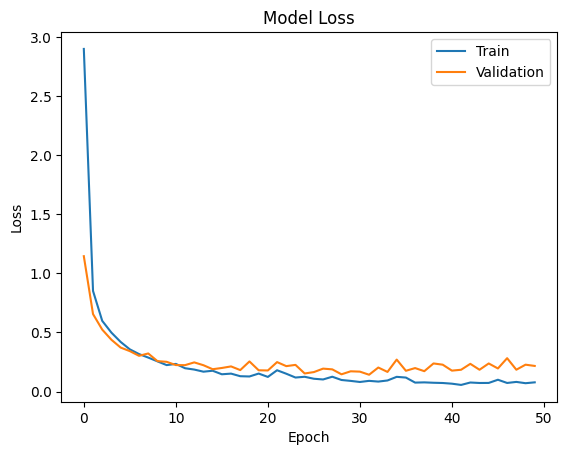

In [79]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

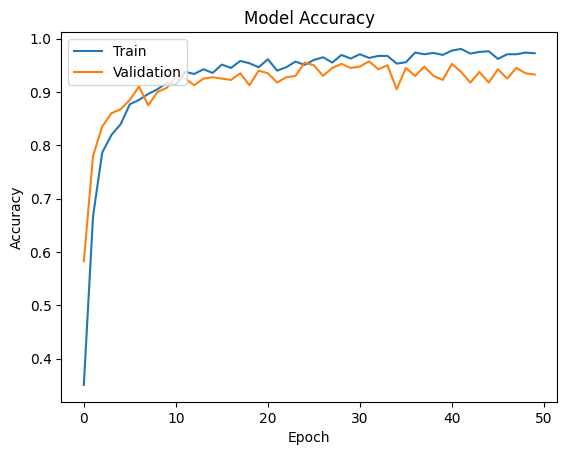

In [80]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


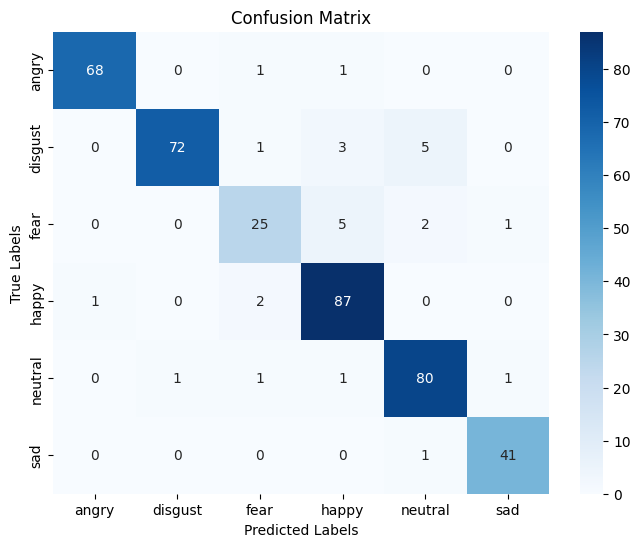

In [81]:
# Get the predicted labels for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert the true labels from one-hot encoding to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']  # Replace with your actual class names
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, labels=range(len(class_names)))

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [82]:
print(report)

              precision    recall  f1-score   support

       angry       0.99      0.97      0.98        70
     disgust       0.99      0.89      0.94        81
        fear       0.83      0.76      0.79        33
       happy       0.90      0.97      0.93        90
     neutral       0.91      0.95      0.93        84
         sad       0.95      0.98      0.96        42

    accuracy                           0.93       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.93      0.93      0.93       400

